# Forth Stage

In [1]:
from get_data import *
from simulation import *
from optimization import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import tqdm
import seaborn as sns
import os
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
res_dict = {}  # Target dictionary to store results, don't update this dictionary for testing different objective function params

In [3]:
files_df = get_path_df()
gb = files_df.groupby(['stock_code', 'side', 'ts', 'tm'])

### Optimization Result of 1 Set of Objective Function Params

In [6]:
for k, df in tqdm.tqdm(gb, desc='GettingSimData', ncols=200, total=len(gb.groups)):
    
    # Get data 
    if k not in res_dict.keys():
        res_dict[k] = get_sim_res(path_ls=df['path'].unique().tolist())
        
    # EoQ cases
    if 'eoq_res' not in res_dict[k].keys():
        res_dict[k]['eoq_res'] = get_sim_res(path_ls=df['path'].unique().tolist(), cond=lambda xdf: xdf['eoq_rep'])
    eoq_score = obj2(res_dict[k]['eoq_res']['pnl'], res_dict[k]['eoq_res']['duration'], **{'lmda': 1, 't_func': lambda x: np.sqrt(x / 1000.)})
    eoq_score = eoq_score[np.logical_and(~np.isnan(eoq_score), ~np.isinf(eoq_score))]
    res_dict[k].update({
        'eoq_scores': eoq_score, 
        'eoq_count_k': len(eoq_score) / 1000, 
        'eoq_score_mean': np.nanmean(eoq_score), 
        'eoq_score_std': np.nanstd(eoq_score)
    })
    
    # Take cases
    if 'take_res' not in res_dict[k].keys():
        res_dict[k]['take_res'] = get_sim_res(path_ls=df['path'].unique().tolist(), cond=lambda xdf: xdf['case'] == 'TAKE')
    take_score = obj2(res_dict[k]['take_res']['pnl'], res_dict[k]['take_res']['duration'], **{'lmda': 1, 't_func': lambda x: np.sqrt(x / 1000.)})
    take_score = take_score[np.logical_and(~np.isnan(take_score), ~np.isinf(take_score))]
    res_dict[k].update({
        'take_scores': take_score, 
        'take_count_k': len(take_score) / 1000, 
        'take_score_mean': np.nanmean(take_score), 
        'take_score_std': np.nanstd(take_score)
    })
    
    # Calculate score
    res_score = obj2(res_dict[k]['pnl'], res_dict[k]['duration'], **{'lmda': 1, 't_func': lambda x: np.sqrt(x / 1000.)})
    res_score = res_score[np.logical_and(~np.isnan(res_score), ~np.isinf(res_score))]
    res_dict[k].update({
        'scores': res_score, 
        'count_k': len(res_score) / 1000, 
        'score_mean': np.nanmean(res_score), 
        'score_std': np.nanstd(res_score), 
        'eoq_%': len(res_dict[k]['eoq_scores']) / len(res_score), 
        'take_%': len(res_dict[k]['take_scores']) / len(res_score), 
    })
    
    for i in ['eoq_', 'take_', '']:
        res_dict[k][f'{i}z_score'] = (res_dict[k][f'{i}score_mean'] + 30) / res_dict[k][f'{i}score_std']

GettingSimData: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7320/7320 [01:18<00:00, 92.66it/s]


2022-11-13 05:23:07.665 | INFO     | optimization.py     :   73 | Plotting 0050 - bid - z_score
2022-11-13 05:23:08.589 | INFO     | optimization.py     :   73 | Plotting 0050 - bid - score_mean
2022-11-13 05:23:10.542 | INFO     | optimization.py     :   73 | Plotting 0050 - bid - score_std
2022-11-13 05:23:13.461 | INFO     | optimization.py     :   73 | Plotting 0050 - bid - eoq_%
2022-11-13 05:23:17.415 | INFO     | optimization.py     :   73 | Plotting 0050 - bid - take_%


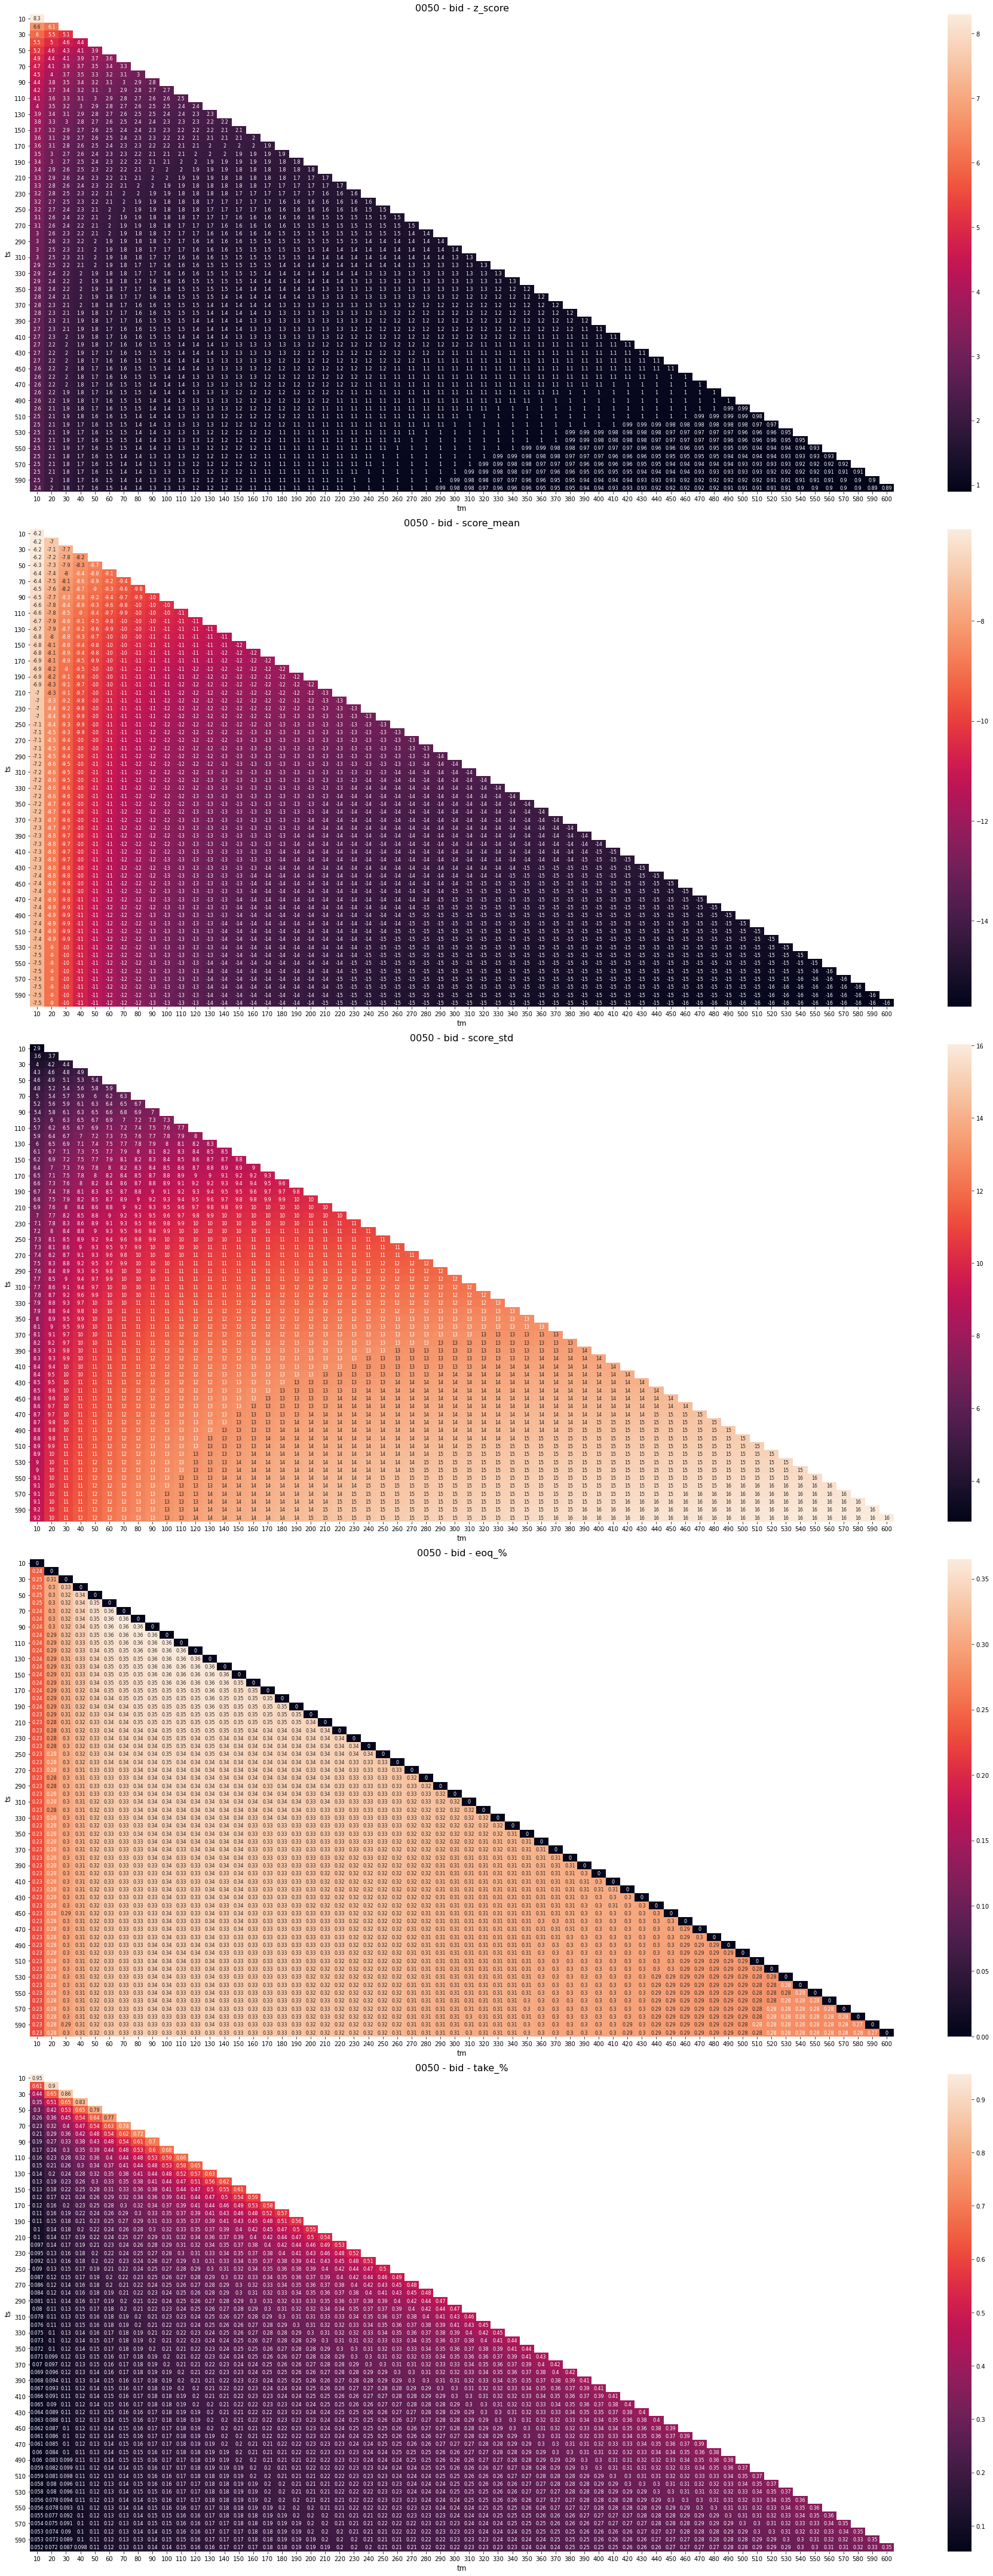

In [7]:
plot_heatmap(stock_code_ls=['0050'], side_ls=['bid'], plot_attri_ls=['z_score', 'score_mean', 'score_std', 'eoq_%', 'take_%'], res_dict=res_dict)

### Vary Lambda

In [ ]:
lmda_ls = list(range(1, 11))
for k, df in tqdm.tqdm(gb, desc='VaryingLambda', ncols=200, total=len(gb.groups)):
    if k not in res_dict.keys():
        res_dict[k] = get_sim_res(path_ls=df['path'].unique().tolist())
    obj_kwargs_ls = [{'lmda': i, 't_func': lambda x: np.sqrt(x / 1000.)} for i in lmda_ls]
    res_score_ls = [obj2(res_dict[k]['pnl'], res_dict[k]['duration'], **obj_kwargs) for obj_kwargs in obj_kwargs_ls]
    res_score_ls = [res_score[np.logical_and(~np.isnan(res_score), ~np.isinf(res_score))] for res_score in res_score_ls]
    res_dict[k].update({
        'score_ls': res_score_ls, 
        'score_mean_ls': [np.nanmean(res_score) for res_score in res_score_ls], 
        'score_std_ls': [np.nanstd(res_score) for res_score in res_score_ls]
    })

In [ ]:
target_stock_code = '2330'
target_side = 'bid'

In [ ]:
plot_key_ls = [(target_stock_code, target_side, str(i), str(i)) for i in range(10, 210, 10)]
plot_attri = 'score_mean'
fig, ax = plt.subplots(figsize=(22, 8))
colors = [(1 - i, 0.5, i / 2) for i in np.linspace(0, 1, len(plot_key_ls))]
for i, k in enumerate(plot_key_ls):
    plot_line = res_dict[k][f'{plot_attri}_ls']
    ax.plot(lmda_ls, plot_line, label='-'.join(k), color=colors[i])
ax.set_title(f'{target_stock_code} | {target_side} | X = lambda - Y = {plot_attri}')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plot_key_ls = [(target_stock_code, target_side, str(i), str(i)) for i in range(10, 210, 10)]
plot_attri = 'score_std'
fig, ax = plt.subplots(figsize=(22, 8))
colors = [(1 - i, 0.5, i / 2) for i in np.linspace(0, 1, len(plot_key_ls))]
for i, k in enumerate(plot_key_ls):
    plot_line = res_dict[k][f'{plot_attri}_ls']
    ax.plot(lmda_ls, plot_line, label='-'.join(k), color=colors[i])
ax.set_title(f'{target_stock_code} | {target_side} | X = lambda - Y = {plot_attri}')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plot_key_ls = [(target_stock_code, target_side, str(i), str(i // 2)) for i in range(10, 210, 10)]
plot_attri = 'score_mean'
fig, ax = plt.subplots(figsize=(22, 8))
colors = [(1 - i, 0.5, i / 2) for i in np.linspace(0, 1, len(plot_key_ls))]
for i, k in enumerate(plot_key_ls):
    plot_line = res_dict[k][f'{plot_attri}_ls']
    ax.plot(lmda_ls, plot_line, label='-'.join(k), color=colors[i])
ax.set_title(f'{target_stock_code} | {target_side} | X = lambda - Y = {plot_attri}')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plot_key_ls = [('2330', 'bid', str(i), str(i)) for i in range(10, 210, 10)]
plot_attri = 'score_std'
fig, ax = plt.subplots(figsize=(22, 8))
colors = [(1 - i, 0.5, i / 2) for i in np.linspace(0, 1, len(plot_key_ls))]
for i, k in enumerate(plot_key_ls):
    plot_line = res_dict[k][f'{plot_attri}_ls']
    ax.plot(lmda_ls, plot_line, label='-'.join(k), color=colors[i])
ax.set_title(f'{target_stock_code} | {target_side} | X = lambda - Y = {plot_attri}')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()